In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class TVDNDetect1(TVDNDetect):
     def PlotRecCurve1(self, idxs=None, bestK=None, quantiles=None, saveFigPath=None, is_imag=False, is_bsp=False):
        """
        idxs: The indices of the sequences to plot 
        bestK: The best K fitted curves to plot according to the errors
        quantiles: The fitted sequences to plot according to the quantiles of errors.
        (priority: idxs > bestK > quantiles)_
        """
        assert self.finalRes is not None, "Run main function first!"
        if idxs is not None and (bestK is not None or quantiles is not None):
            warnings.warn("idxs is provided, so bestK or quantiles will be ignored", UserWarning)
        if idxs is None and bestK is not None and quantiles is not None:
            warnings.warn("bestK is provided, so quantiles will be ignored", UserWarning)
        if self.RecResCur is None:
            self.__GetRecResCur()
        if is_imag:
            RecYmatCur = self.RecResCur.EstXmatImag
        else:
            RecYmatCur = self.RecResCur.EstXmatReal
        d, n = self.nYmat.shape
        if idxs is not None:
            assert d>=np.max(idxs) & np.min(idxs)>=0, "Wrong index!"
        else:
            diff = RecYmatCur - self.nYmat
            errs2 = np.sum(diff**2, axis=1)/np.sum(self.nYmat**2, axis=1)
            errs = np.sqrt(errs2)
            argidxs = np.argsort(errs)
            if quantiles is None and bestK is None:
                qidxs = np.quantile(np.arange(d), [0, 0.25, 0.5, 0.75, 1]).astype(np.int)
            elif bestK is not None:
                qidxs = argidxs[:bestK]
            else:
                qidxs = np.quantile(np.arange(d), quantiles).astype(np.int)
            idxs = argidxs[qidxs]
        if self.showProgress:
            print(f"The plot indices are {idxs}.")
        
        
        numSubPlot = len(idxs)
        numRow = ((numSubPlot-1) // 3) + 1
        
        plt.figure(figsize=[15, 5*numRow])

        numP = 3000
        for i, idx, in enumerate(idxs):
            plt.subplot(numRow, 3, i+1)
            if not is_imag:
                plt.plot(self.ptime[:numP], self.nYmat[idx, :numP], "-", label="Observed")
            plt.plot(self.ptime[:numP], RecYmatCur[idx, :numP], "-.", label="Reconstructed")
            if is_bsp:
                plt.plot(self.ptime[:numP], self.Xmat[idx, :numP], "r--", label="B-spline Estimator")
            plt.legend()
        if saveFigPath is None:
            plt.show() 
        else:
            plt.savefig(saveFigPath)

In [4]:
resDir = Path("../results")
dataDir = Path("../data")

In [6]:
filname = Path("subj1_filtered_Edge_Removed.mat")
MEG = loadmat(dataDir/filname)

In [7]:
MEG = MEG["Y"]

# 1. Dection after B-spline 

In [8]:
MEGBspDet = TVDNDetect1(Ymat=MEG, saveDir=None, dataType="MEG", fName="subj1_filetered_full", r=6, kappa=2.65, freq=60, lamb=1e-6)

The parameters for detection are:
{'Lmin': 60,
 'MaxM': 19,
 'T': 2,
 'decimateRate': 10,
 'downRate': 20,
 'fName': 'subj1_filetered_full',
 'fct': 0.5,
 'freq': 60,
 'is_detrend': False,
 'kappa': 2.65,
 'lamb': 1e-06,
 'nbasis': 10,
 'plotfct': 30,
 'r': 6}


In [9]:
MEGBspDet.Screening()

R[write to console]: 
Attaching package: ‘signal’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, poly




## Run the Main Function

In [10]:
MEGBspDet()

### Check the current results

In [11]:
print(MEGBspDet)

+-------------+----------------+------------------------+------+
| Num of CPTs | Estiamted CPTs |          MSE           | Rank |
+-------------+----------------+------------------------+------+
|      0      |       []       | 1.6679383102642714e+17 |  6   |
+-------------+----------------+------------------------+------+


## Tuning the kappa parameters

In [12]:
kappas = np.arange(1.00, 3, 0.01)
MEGBspDet.TuningKappa(kappas)

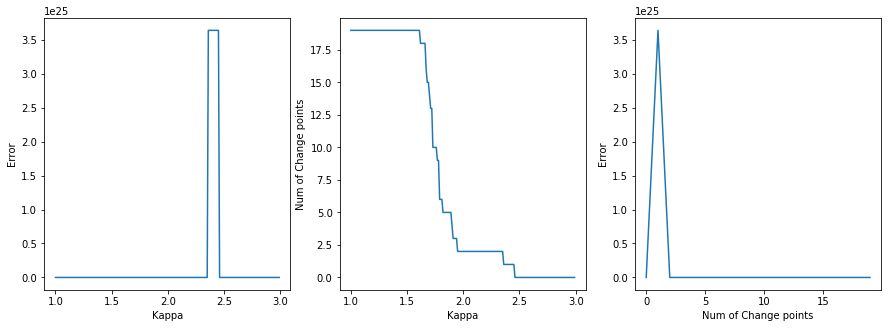

In [13]:
MEGBspDet.PlotKappaErrCurve()

### Then we  can check the best kappa parameters w.r.t mean square errors

In [14]:
print("The optimal kappas are:", MEGBspDet.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", MEGBspDet.optKappaOptNumChg)
print("The optimal number of change point is:", MEGBspDet.optNumChg)

The optimal kappas are: 1.6800000000000006
The optimal number of change point under the range of kappa we speicified is: 15
The optimal number of change point is: 15


###  Update the estimated change point set based on optimal kappa

You can also specify the number of change points you want via providing the augment `numChg`, then the `UpdateEcpts` will update the current estimated change point set accordingly.

In such case, the `PlotXXX` function will plot the curves under the number of change point you provided

In [15]:
MEGBspDet.UpdateEcpts(numChg=16)
MEGBspDet.UpdateEcpts()

### Check the results after updating

In [16]:
print(MEGBspDet)

+-------------+--------------------------------------------------------------------------+-------------------+------+
| Num of CPTs |                              Estiamted CPTs                              |        MSE        | Rank |
+-------------+--------------------------------------------------------------------------+-------------------+------+
|      15     | [  67.  435.  502. 1203. 1621. 1772. 1873. 2057. 2124. 2372. 2475. 2892. | 34.15238741235595 |  6   |
|             |                            2992. 3093. 3293.]                            |                   |      |
+-------------+--------------------------------------------------------------------------+-------------------+------+


### Plot the detection results under the optimal kappa



### Plot the reconstructed curve under the optimal kappa

 Similarly, you can specify the `saveFigPath` to save the figure
 
 You should specify the subsets of sequences you want to plot via `idxs` argument

The plot indices are [36 28 58 27 61].


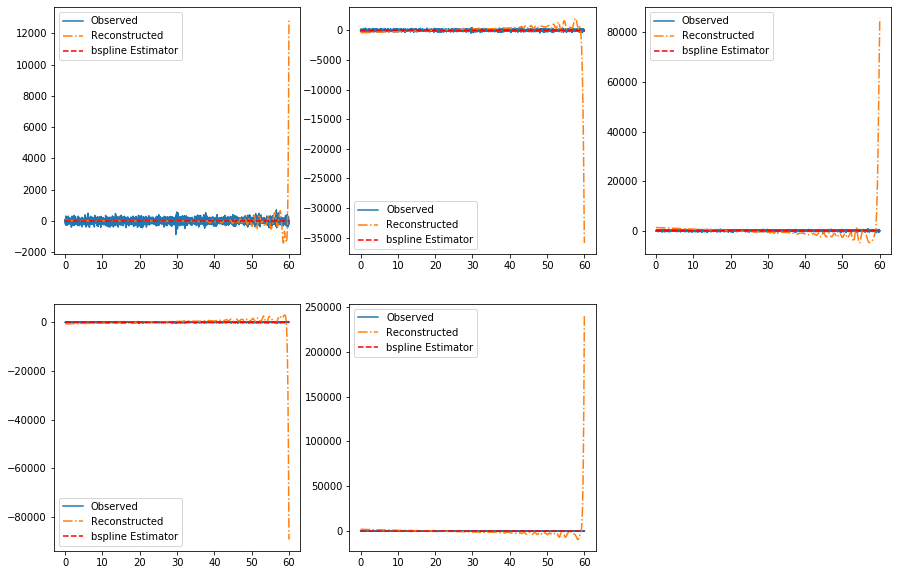

In [18]:
MEGBspDet.PlotRecCurve(is_smoothCurve=1, saveFigPath=None)

### Plot after removing the last several observations

The plot indices are [36, 28, 58, 27, 61].


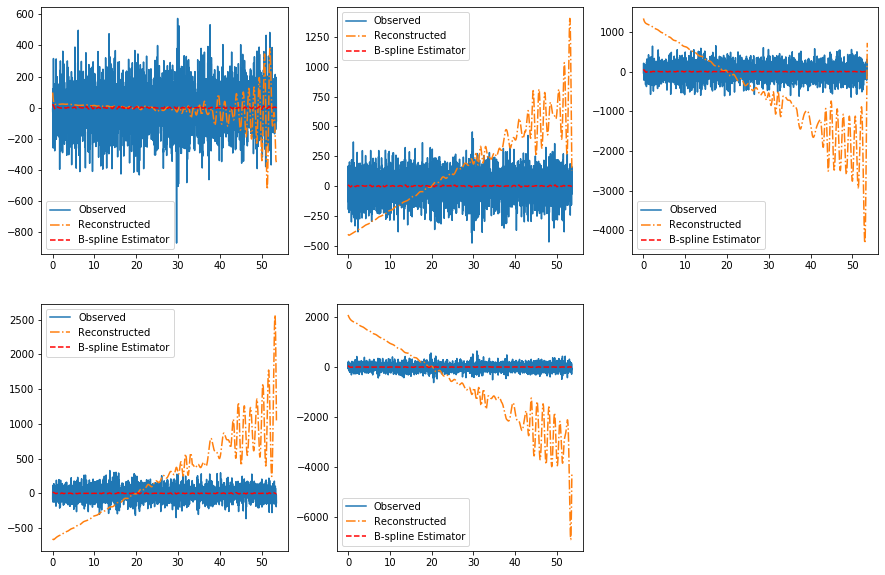

In [19]:
MEGBspDet.PlotRecCurve1(idxs=[36, 28, 58, 27, 61], is_bsp=1, saveFigPath=None)

# Detection after Fourier Regression

In [40]:
MEGFourDet= TVDNDetect1(Ymat=MEG, saveDir=None, smoothType="fourier", dataType="MEG", 
                        fName="subj1_filetered_full", r=6, kappa=2.65, freq=60, lamb=1e-6, 
                       nbasis=10)

The parameters for detection are:
{'Lmin': 60,
 'MaxM': 19,
 'T': 2,
 'decimateRate': 10,
 'downRate': 20,
 'fName': 'subj1_filetered_full',
 'fct': 0.5,
 'freq': 60,
 'is_detrend': False,
 'kappa': 2.65,
 'lamb': 1e-06,
 'nbasis': 10,
 'plotfct': 30,
 'r': 6}


In [41]:
MEGFourDet.Screening()

In [42]:
MEGFourDet()

## Tuning the kappa parameters

In [43]:
kappas = np.arange(1.00, 3, 0.01)
MEGFourDet.TuningKappa(kappas)

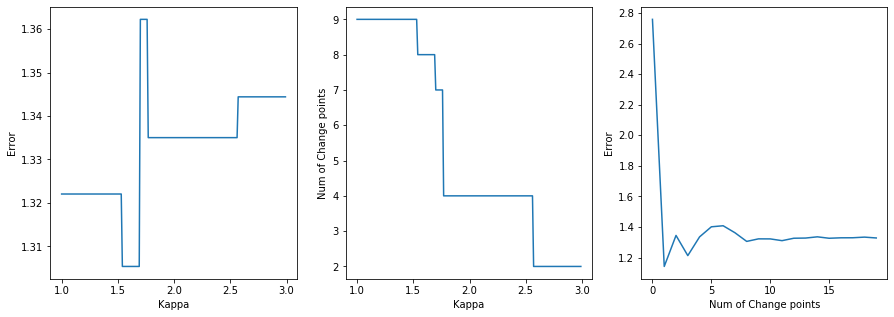

In [44]:
MEGFourDet.PlotKappaErrCurve()

### Then we  can check the best kappa parameters w.r.t mean square errors

In [45]:
print("The optimal kappas are:", MEGFourDet.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", MEGFourDet.optKappaOptNumChg)
print("The optimal number of change point is:", MEGFourDet.optNumChg)

The optimal kappas are: 1.5400000000000005
The optimal number of change point under the range of kappa we speicified is: 8
The optimal number of change point is: 1


###  Update the estimated change point set based on optimal kappa

You can also specify the number of change points you want via providing the augment `numChg`, then the `UpdateEcpts` will update the current estimated change point set accordingly.

In such case, the `PlotXXX` function will plot the curves under the number of change point you provided

In [46]:
MEGFourDet.UpdateEcpts(numChg=8)

### Check the results after updating

In [47]:
print(MEGFourDet)

+-------------+---------------------------------------------------+--------------------+------+
| Num of CPTs |                   Estiamted CPTs                  |        MSE         | Rank |
+-------------+---------------------------------------------------+--------------------+------+
|      8      | [ 384.  477.  997. 2157. 2674. 2803. 2880. 2979.] | 1.3053690293129043 |  6   |
+-------------+---------------------------------------------------+--------------------+------+


### Plot the reconstructed curve under the optimal kappa

 Similarly, you can specify the `saveFigPath` to save the figure
 
 You should specify the subsets of sequences you want to plot via `idxs` argument

The plot indices are [36, 28, 58, 27, 61].


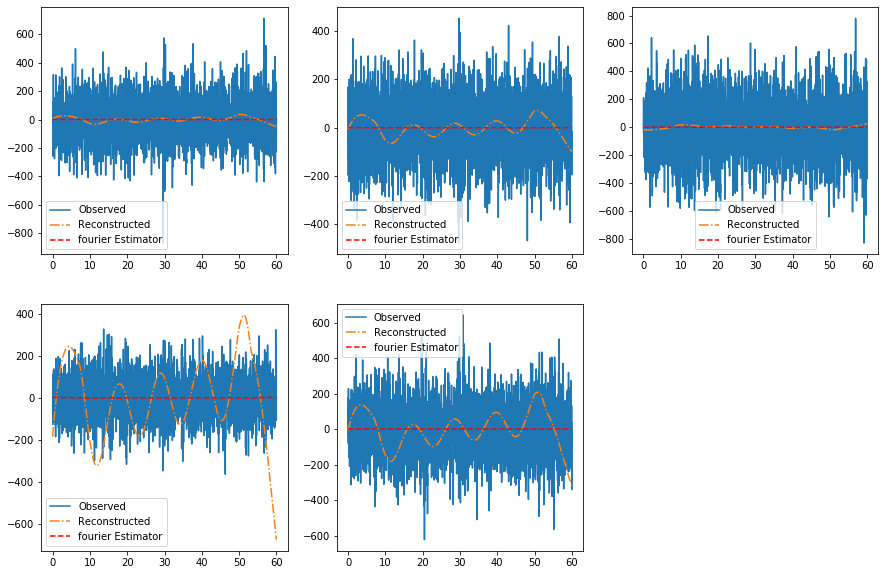

In [48]:
MEGFourDet.PlotRecCurve(idxs=[36, 28, 58, 27, 61], is_smoothCurve=1, saveFigPath=None)

The plot indices are [36, 28, 58, 27, 61].


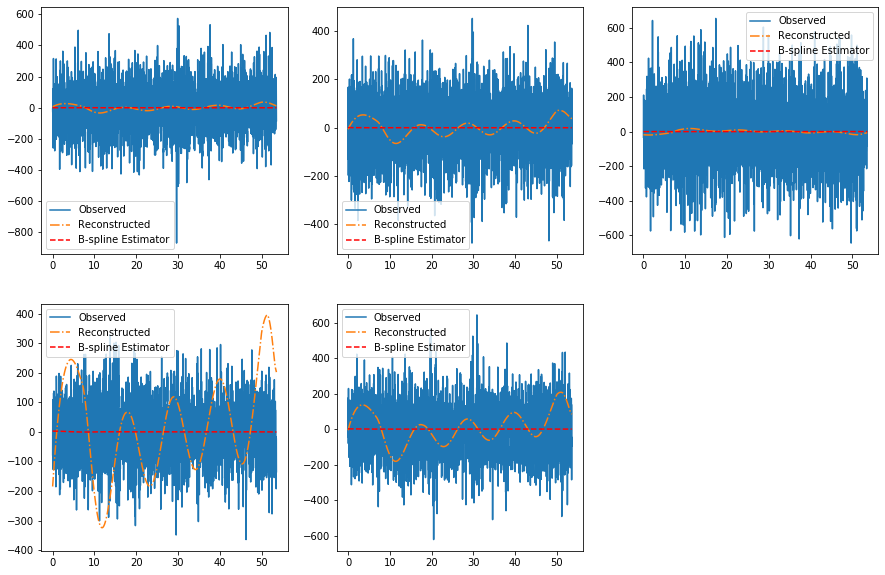

In [49]:
MEGFourDet.PlotRecCurve1(idxs=[36, 28, 58, 27, 61], is_bsp=1, saveFigPath=None)